In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
from time import sleep
import sqlite3
import seaborn as sns
import numpy as np

In [36]:
url = 'https://www.atptour.com/en/rankings/singles/?rankDate=2020-9-14&countryCode=all&rankRange=1-200'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')

In [37]:
conn = sqlite3.connect('tennisAnalysis.db')
c = conn.cursor()

In [38]:
c.execute('CREATE TABLE IF NOT EXISTS atpData (ranking INTEGER, player TEXT, age INTEGER, weight REAL, height INTEGER, wins INTEGER, losses INTEGER, titles INTEGER, aces INTEGER, doubleFaults INTEGER)')

In [39]:
for row in soup.select('tbody tr'):
    ranking = row.select_one('.rank-cell').text.strip()
#     print(ranking)
    player = row.select_one('.player-cell a').text.strip()
#     print(player)
    age = row.select_one('.age-cell').text.strip()
#     print(age)
    link = row.select_one('.player-cell a')['href']
    player_page = 'https://www.atptour.com' + link
    sleep(10)
    
    r2 = requests.get(player_page)
    soup2 = BeautifulSoup(r2.content, 'html.parser')
    try:
        weight = soup2.select_one('.table-weight-kg-wrapper').text.strip()
        #print(weight)
    except Exception as e:
        weight = None
    try:
        height = soup2.select_one('.table-height-cm-wrapper').text.strip()
#       print(height)
    except Exception as e:
        height = None
    #grab the link for scraping the wins, losses and number of titles
    w_l = soup2.select_one('#fedex-atp-win-loss_SectionLink a')['href']
    w_l_page = 'https://www.atptour.com' + w_l 
    sleep(10)
    
    r3 = requests.get(w_l_page)
    soup3 = BeautifulSoup(r3.content, 'html.parser')
    #grab the second inner-win-loss cells class, which is the one that have the wins and losses
    try:
        wins_losses = soup3.select('.inner-win-loss-cells')[1]
        wins = wins_losses.select_one('tr td:first-child').text.strip()
#         print(wins)
        losses = wins_losses.select_one('tr td:nth-child(3)').text.strip()
#         print(losses)
        #select the first row, that contains the number of titles
        titles_row = soup3.select_one('.mega-table tbody tr')
        #for some reason last-child selector wasnt working, had to find other solution
        titles = titles_row.select_one("td:nth-child(6)").text.strip()
#         print(titles)
    except Exception as e:
        wins = None
        losses = None
        titles = None
    #grab link for extracting serve stats
    stats = soup3.select_one('#player-stats_SectionLink a')['href']
    stats_page = 'https://www.atptour.com' + stats
    sleep(10)
    
    r4 = requests.get(stats_page)
    soup4 = BeautifulSoup(r4.content, 'html.parser')
    try:
        aces_row = soup4.select_one('.mega-table tbody tr')
        aces = aces_row.select_one('td:last-child').text.strip()
#         print(aces)
        #grabs the second tr of tbody inside mega table class, which is the one that has the number of double faults
        dblFaults_row = soup4.select('.mega-table tbody tr')[1]
        dblFaults = dblFaults_row.select_one('td:last-child').text.strip()
#         print(dblFaults)
    except Exception as e:
        aces = None
        dblFaults = None
    c.execute("INSERT INTO atpData VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", (ranking, player, age, weight, height, wins, losses, titles, aces, dblFaults))
    conn.commit()
#     print()
    
c.close()
conn.close()


In [2]:
#import db data and convert to pandas dataframe
conn = sqlite3.connect('tennisAnalysis.db')
df = pd.read_sql_query("SELECT * FROM atpData", conn)
conn.close()

In [4]:
df

,ranking,player,age,weight,height,wins,losses,titles,aces,doubleFaults
0,1,Novak Djokovic,33,(77kg),(188cm),924.0,188.0,81.0,"5,813","2,438"
1,2,Rafael Nadal,34,(85kg),(185cm),992.0,201.0,85.0,"3,544","1,856"
2,3,Dominic Thiem,27,(79kg),(185cm),291.0,153.0,17.0,"2,522","1,214"
3,4,Roger Federer,39,(85kg),(185cm),1242.0,271.0,103.0,"11,344","2,742"
4,5,Daniil Medvedev,24,(83kg),(198cm),146.0,82.0,7.0,"1,725",770
...,...,...,...,...,...,...,...,...,...,...
194,196,Andrea Collarini,28,(80kg),(185cm),NaN,NaN,NaN,None,None
195,197,Ramkumar Ramanathan,25,(80kg),(188cm),22.0,27.0,0.0,253,134
196,198,Marius Copil,29,(87kg),(193cm),63.0,89.0,0.0,"1,404",397
197,199,Brandon Nakashima,19,(77kg),(185cm),3.0,2.0,0.0,34,12


In [3]:
#remove parenthesis and units from weight/height
df['weight'] = df.loc[:, 'weight'].str.replace(r"\((.*)\)", r'\1')
df['height'] = df.loc[:, 'height'].str.replace(r"\((.*)\)", r'\1')

In [4]:
#remove units from both columns
df['weight'] = df.loc[:, 'weight'].str.replace(r"(kg)", '')
df['height'] = df.loc[:, 'height'].str.replace(r"(cm)", '')

In [5]:
#remove commas from numbers, since str.replace is for strings, we need to conver our columns to strings and then reconvert back to ints
#drop None values, since it prevents us from converting back to int
df = df.dropna()
df['aces'] = df['aces'].astype(str).str.replace(",", "").astype(int)
df['doubleFaults'] = df['doubleFaults'].astype(str).str.replace(",", "").astype(int)

In [6]:
df['weight'] = df['weight'].astype(int)
df['height'] = df['height'].astype(int)

In [11]:
df.head()

,ranking,player,age,weight,height,wins,losses,titles,aces,doubleFaults
0,1,Novak Djokovic,33,77,188,924.0,188.0,81.0,5813,2438
1,2,Rafael Nadal,34,85,185,992.0,201.0,85.0,3544,1856
2,3,Dominic Thiem,27,79,185,291.0,153.0,17.0,2522,1214
3,4,Roger Federer,39,85,185,1242.0,271.0,103.0,11344,2742
4,5,Daniil Medvedev,24,83,198,146.0,82.0,7.0,1725,770


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 198
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ranking       194 non-null    int64  
 1   player        194 non-null    object 
 2   age           194 non-null    int64  
 3   weight        194 non-null    int32  
 4   height        194 non-null    int32  
 5   wins          194 non-null    float64
 6   losses        194 non-null    float64
 7   titles        194 non-null    float64
 8   aces          194 non-null    int32  
 9   doubleFaults  194 non-null    int32  
dtypes: float64(3), int32(4), int64(2), object(1)
memory usage: 13.6+ KB


In [7]:
df['games_played'] = df['wins'] + df['losses']
df['acesPerMatch'] = round(df['aces'] / df['games_played'])
df['doubleFaultsPerMatch'] = round(df['doubleFaults'] / df['games_played'])
df['win_percentage'] = round(df['wins'] / df['games_played'], 2)

In [96]:
df

,ranking,age,weight,height,wins,losses,titles,aces,doubleFaults,acesPerMatch,doubleFaultsPerMatch,games_played,win_percentage
player,,,,,,,,,,,,,
Novak Djokovic,1,33,77,188,924.0,188.0,81.0,5813,2438,5.0,2.0,1112.0,0.83
Rafael Nadal,2,34,85,185,992.0,201.0,85.0,3544,1856,3.0,2.0,1193.0,0.83
Dominic Thiem,3,27,79,185,291.0,153.0,17.0,2522,1214,6.0,3.0,444.0,0.66
Roger Federer,4,39,85,185,1242.0,271.0,103.0,11344,2742,7.0,2.0,1513.0,0.82
Daniil Medvedev,5,24,83,198,146.0,82.0,7.0,1725,770,8.0,3.0,228.0,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thai-Son Kwiatkowski,194,25,82,188,0.0,5.0,0.0,42,26,8.0,5.0,5.0,0.00
Ramkumar Ramanathan,197,25,80,188,22.0,27.0,0.0,253,134,5.0,3.0,49.0,0.45
Marius Copil,198,29,87,193,63.0,89.0,0.0,1404,397,9.0,3.0,152.0,0.41


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 198
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ranking               194 non-null    int64  
 1   player                194 non-null    object 
 2   age                   194 non-null    int64  
 3   weight                194 non-null    int32  
 4   height                194 non-null    int32  
 5   wins                  194 non-null    float64
 6   losses                194 non-null    float64
 7   titles                194 non-null    float64
 8   aces                  194 non-null    int32  
 9   doubleFaults          194 non-null    int32  
 10  games_played          194 non-null    float64
 11  acesPerMatch          194 non-null    float64
 12  doubleFaultsPerMatch  194 non-null    float64
 13  win_percentage        194 non-null    float64
dtypes: float64(7), int32(4), int64(2), object(1)
memory usage: 19.7+ KB


we are gonna analyze the acerPerMatch variable with respect to the others

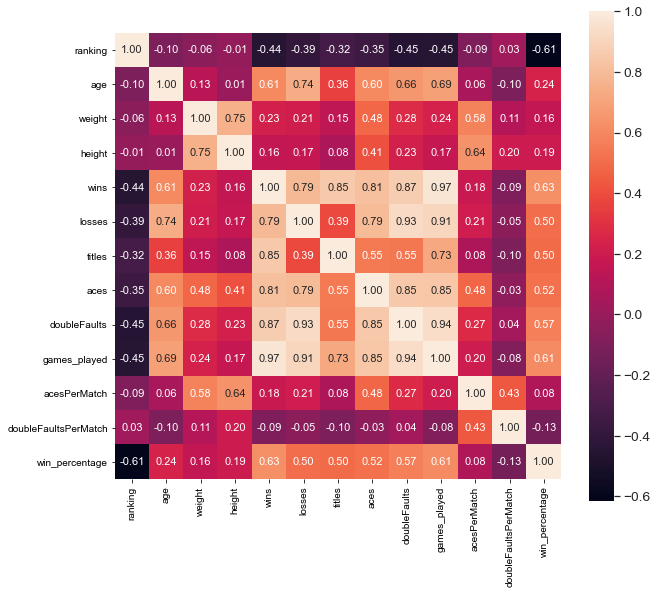

In [13]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(10,9))
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, ax=ax)
plt.show()

as we can see, there are variables that are strongly correlated with others, for example acesPerMatch and height, wich makes sense because the taller you are the more aces you land.
another strong correlation is the titles variable and wins, which is also reasonable.

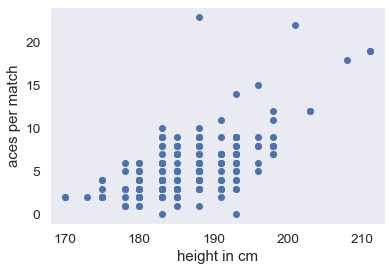

In [14]:
plt.scatter(x=df['height'], y=df['acesPerMatch'])
plt.ylabel('aces per match')
plt.xlabel('height in cm')
plt.grid()

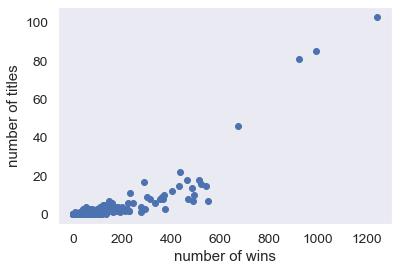

In [15]:
plt.scatter(x=df['wins'], y=df['titles'])
plt.ylabel('number of titles')
plt.xlabel('number of wins')
plt.grid()

#### what are the average height and age in this sport based on the top 200 players?

In [56]:
df.mean()

ranking                   98.221649
age                       27.608247
weight                    80.386598
height                   186.721649
wins                     117.170103
losses                    92.108247
titles                     3.685567
aces                    1371.520619
doubleFaults             574.144330
acesPerMatch               5.567010
doubleFaultsPerMatch       2.871134
dtype: float64

In [57]:
df.describe()

,ranking,age,weight,height,wins,losses,titles,aces,doubleFaults,acesPerMatch,doubleFaultsPerMatch
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,98.221649,27.608247,80.386598,186.721649,117.170103,92.108247,3.685567,1371.520619,574.144330,5.567010,2.871134
std,57.209526,4.517225,6.904982,6.789572,183.399637,100.049281,11.992619,2259.566713,727.538927,3.603128,1.365334
min,1.000000,17.000000,64.000000,170.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,49.250000,24.000000,76.000000,183.000000,9.000000,16.000000,0.000000,82.000000,63.000000,3.000000,2.000000
50%,97.500000,27.500000,80.000000,185.000000,40.500000,50.000000,0.000000,415.000000,268.500000,5.000000,3.000000
75%,145.750000,31.000000,85.000000,191.000000,138.750000,148.750000,3.000000,1651.500000,843.500000,7.000000,3.000000
max,200.000000,41.000000,108.000000,211.000000,1242.000000,451.000000,103.000000,13619.000000,3778.000000,23.000000,12.000000


#### who has the most aces per match?

In [16]:
df.set_index('player', inplace=True)

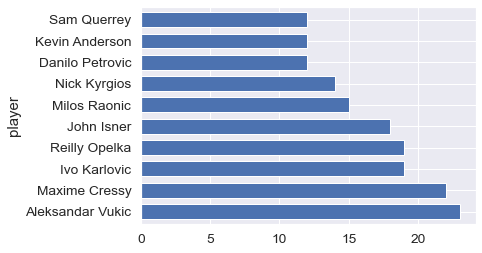

In [23]:
df['acesPerMatch'].nlargest(10).sort_values(ascending=False).plot(kind='barh', width=0.7)

In [79]:
df.loc[:, ['acesPerMatch', 'games_played', 'aces']].sort_values(by='acesPerMatch', ascending=False)

,acesPerMatch,games_played,aces
player,,,
Aleksandar Vukic,23.0,1.0,23
Maxime Cressy,22.0,2.0,44
Ivo Karlovic,19.0,711.0,13619
Reilly Opelka,19.0,88.0,1658
John Isner,18.0,705.0,12345
...,...,...,...
Frederico Ferreira Silva,1.0,11.0,9
Lorenzo Giustino,1.0,4.0,3
Emilio Gomez,1.0,26.0,21


as we can see the first and second players are not very representative, their aces indicator is only high because the played just a few games, so i conclude that Karlovic is the player that makes more aces per match, with 19 aces every match

#### who has the most doble faults per match?

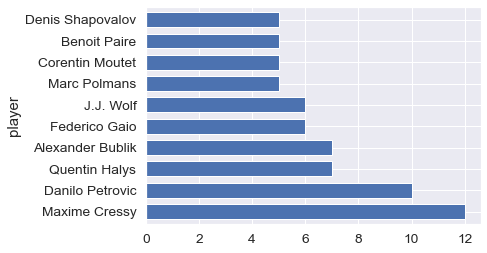

In [25]:
df['doubleFaultsPerMatch'].nlargest(10).sort_values(ascending=False).plot(kind='barh', width=0.7)

In [87]:
df.loc[:, ['doubleFaultsPerMatch', 'games_played', 'doubleFaults']].sort_values(by='doubleFaultsPerMatch', ascending=False).head(50)

,doubleFaultsPerMatch,games_played,doubleFaults
player,,,
Maxime Cressy,12.0,2.0,25
Danilo Petrovic,10.0,1.0,10
Quentin Halys,7.0,26.0,181
Alexander Bublik,7.0,66.0,432
Federico Gaio,6.0,12.0,68
J.J. Wolf,6.0,4.0,26
Thai-Son Kwiatkowski,5.0,5.0,26
Bradley Klahn,5.0,54.0,249
Benoit Paire,5.0,458.0,2216


again, the first 2 are not representative, quentin halys is the player that makes more double faults per match.

#### of the top 50, who has the higher win percentage?

In [115]:
df.loc[:, ['win_percentage', 'ranking']].head(50).sort_values(by='win_percentage', ascending=False)

,win_percentage,ranking
player,,
Novak Djokovic,0.83,1
Rafael Nadal,0.83,2
Roger Federer,0.82,4
Milos Raonic,0.68,19
Kei Nishikori,0.68,35
Dominic Thiem,0.66,3
Alexander Zverev,0.66,7
Marin Cilic,0.65,40
Stefanos Tsitsipas,0.64,6


its no surprise that Djokovic, Nadal and Federer have the most win percentages, since they've been dominating this sport for years. Other interesting mentions are Nishikori and Raonic, who have high win percentage but are not top 10,  (35 and 19 respectively).

#### what are the average stats on the top 10 players?

we are gonna leave out Djovokic, Nadal and Federer, because theyve been in the top ten for years, and are just gonna skew our analysis. we are only interested in what does it take to be a top ten

In [38]:
top_ten = df.copy()
top_ten = top_ten.head(10)

In [39]:
top_ten.drop(['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'], inplace=True)

In [40]:
top_ten.mean()

ranking                    6.857143
age                       26.571429
weight                    85.142857
height                   192.285714
wins                     236.714286
losses                   132.428571
titles                     8.857143
aces                    2427.714286
doubleFaults            1103.857143
games_played             369.142857
acesPerMatch               6.857143
doubleFaultsPerMatch       2.714286
win_percentage             0.635714
dtype: float64

on average, you need to win 9 titles, play 370 games and have a 63% win ratio to be in the top 10 players of the world